# **Computing saliency masks with the PAIRML saliency library in TF1**
- This notebook demonstrates a number of saliency techniques using the Inception V3 convolutional neural network (a deep learning technology).
- This notebook assumes you have the saliency pip package installed. 
- This notebook shows the following techniques
    - Vanilla Gradients
    - Guided Backpropogation
    - Integrated Gradients
    - XRAI

**Installation packages **

In [ ]:
#To install run (use pip3 for python 3.x):
#https://www.tensorflow.org/hub/installation
#TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere.
!pip install saliency[tf1] tensorflow_hub

In [4]:
# imports
#TensorFlow is a free and open-source software library for machine learning. It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks.
#tf.compat allows you to write code that works both in TensorFlow 1.x and 2.x. 
import tensorflow.compat.v1 as tf

#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
import numpy as np

#Pillow (Python Imaging Library) is a free and open-source additional library for the Python programming language that adds support for opening, manipulating, and saving many different image file formats. 
#PIL.Image provides functions to load images from files, and to create new images.
import PIL.Image

#Matplotlib is a plotting library for the Python
from matplotlib import pylab as P

# From Saliecny repository.
import saliency.tf1 as saliency

#Output of plotting commands is displayed inline (directly below the code cell that produced it).
%matplotlib inline

**Utility methods**

In [7]:
#define different methods to load and show images
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = (im * 255).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = np.asarray(im)
  return im / 255

**Loading the Inception model graph**
- Run the following cell to download the network. This assumes you have the tensorflow_hub pip package installed. To install run (use pip3 for python 3.x):
- Alternatively, you to use/load the pretrained network/modle 

In [ ]:
pip install tensorflow-hub

In [11]:
import tensorflow_hub as hub

model_path = "https://tfhub.dev/google/imagenet/inception_v3/classification/3"
graph = tf.Graph()
sess = tf.Session(graph=graph)
with graph.as_default():
  hub.Module(model_path)
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())

In [12]:
#Logits are values that are used as input to softmax.
# In deeplearning Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities
with graph.as_default():
  images = graph.get_tensor_by_name('module/hub_input/images:0')
  logits = graph.get_tensor_by_name('module/InceptionV3/Logits/SpatialSqueeze:0')
  # Construct the scalar neuron tensor.
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[:,neuron_selector]

  # Construct tensor for predictions.
  prediction = tf.argmax(logits, 1)

**Load image to compute the image class **
- It will predict the image class and then later use this class to computer saliency accordingly. 

In [ ]:
# Load the image
#im = LoadImage('./doberman.png')
im = LoadImage('/content/sample_data/3.jpg')
# Show the image
ShowImage(im)

# Make a prediction. 
prediction_class = sess.run(prediction, feed_dict = {images: [im]})[0]

print("Prediction class: " + str(prediction_class))  

**Method 1 - Vanilla Gradients**

Source: https://www.researchgate.net/profile/Aaron-Courville/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network/links/53ff82b00cf24c81027da530/Visualizing-Higher-Layer-Features-of-a-Deep-Network.pdf

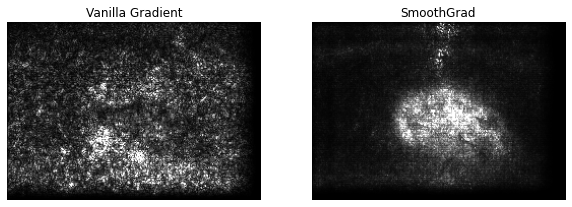

In [15]:
#Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, feed_dict = {neuron_selector: prediction_class})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

**Method 2 - Guided Backprop & SmoothGrad**

Source: https://arxiv.org/abs/1412.6806


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


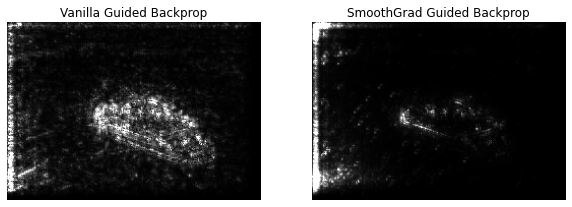

In [16]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.

guided_backprop = saliency.GuidedBackprop(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
  im, feed_dict = {neuron_selector: prediction_class})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
  im, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))

**Method 3 - Integrated Gradients & SmoothGrad**

Source: https://arxiv.org/abs/1703.01365

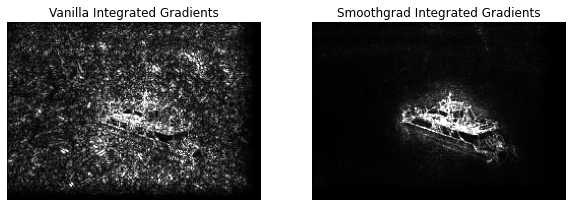

In [17]:
#Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients(graph, sess, y, images)

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

**Method 4- XRAI: Better Attributions Through Regions**

Source: https://arxiv.org/abs/1906.02825

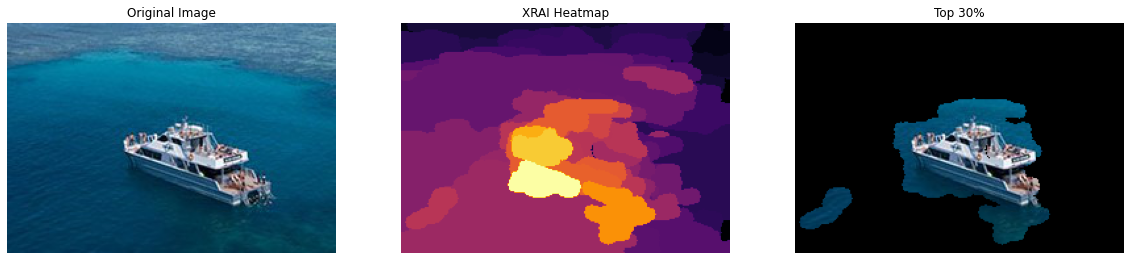

In [18]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, images)

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, feed_dict={neuron_selector: prediction_class}, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 70)
im_mask = np.array(im)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))